## Modelling Draft <br>
Framework: Tensorflow Keras <br>
Base models to test: <br>
<li>Xception </li>
<li>MobileNet ✓</li>
<li>NasNet Mobile </li>

#### Import Packages

In [1]:
# import numpy as np
# from PIL import Image
# from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import random
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from time import perf_counter

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('All modules are loaded')

All modules are loaded


In [2]:
#Labels
# t_stg= ['is','1','1a','1b','1c','2','2a','2b','3','4']
# n_stg = ['0','1','2','3']
# m_stg = ['0','1','1a','1b','1c','2','3'] 

#Load the image batches, labels == t,m,n
t_raw_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\raw_ct_delimited.csv',usecols=['filenames','t'])
raw_dir = r'C:\Users\lzsnc\Desktop\Raw CT Images'
# seg_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\segmented ct image files.csv',usecols=['filenames','labels'])
# seg_dir = r'C:\Users\lzsnc\Desktop\Masked CT images'
# seg_df.head()
# os.chdir(r'C:\Users\lzsnc\Desktop\Raw CT Images')
t_raw_df.head()

In [3]:
t_raw_df.head()

,filenames,t
0,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-13.tiff,2b
1,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-14.tiff,2b
2,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-15.tiff,2b
3,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-16.tiff,2b
4,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-17.tiff,2b


#### Split Dataset: <br>
80% Train, 20% Test

In [4]:
t_train_df, t_test_df = train_test_split(t_raw_df, test_size=0.2, random_state=42) 
t_train_df.tail()

,filenames,t
29802,Lung_Dx-G0060_01-21-2011-NA-PET01PTheadlung Adult-07418_10.000000-Thorax 1.0 B70f-17914_1-168.tiff,2a
5390,Lung_Dx-A0170_12-02-2010-NA-PET03CBMWholebodyFirstHead Adult-02190_10.000000-Thorax 1.0 B70f-48719_1-150.tiff,2a
860,Lung_Dx-A0030_10-08-2008-NA-LUNGCTA-12839_2.000000-5mm Stnd SS50-99357_3-034.tiff,1c
15795,Lung_Dx-A0242_06-30-2010-NA-PET03WholebodyFirstHead Adult-08887_10.000000-Thorax 1.0 B70f-74050_1-077.tiff,3
23654,Lung_Dx-G0017_10-24-2009-NA-LUNGC-80644_2.000000-A phase 5mm Stnd SS50-33209_2-033.tiff,2


#### Train/Test for 'T' Stage

In [5]:
train_batch = 32
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,)

t_train_ds = train_datagen.flow_from_dataframe(
    dataframe=t_train_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='t',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=32
)

Found 24250 validated image filenames belonging to 10 classes.


In [6]:
np.unique(t_train_ds.classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Test Image Generator

In [7]:
test_batch = 32
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
t_test_ds = test_datagen.flow_from_dataframe(
    dataframe=t_test_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='t',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=False, #re-run this!
    seed=32 
)

Found 6063 validated image filenames belonging to 10 classes.


In [8]:
#Validate the number of T-stage classes
t_class_dict = t_train_ds.class_indices
print(t_class_dict)
t_num_classes = len(t_class_dict)
t_num_classes

{'1': 0, '1a': 1, '1b': 2, '1c': 3, '2': 4, '2a': 5, '2b': 6, '3': 7, '4': 8, 'is': 9}


10

In [9]:
t_class_dict

{'1': 0,
 '1a': 1,
 '1b': 2,
 '1c': 3,
 '2': 4,
 '2a': 5,
 '2b': 6,
 '3': 7,
 '4': 8,
 'is': 9}

Add Weights to Solve Data Imbalance

In [10]:
t_class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=np.unique(t_train_ds.classes),
           y=t_train_ds.classes)
t_class_weights = dict(zip(np.unique(t_train_ds.classes), t_class_weights))
t_class_weights

{0: 6.536388140161725,
 1: 6.680440771349862,
 2: 1.1232051875868458,
 3: 0.3932219880006486,
 4: 2.3498062015503876,
 5: 0.5871670702179177,
 6: 1.2506446621970089,
 7: 0.38987138263665594,
 8: 1.3222464558342422,
 9: 69.28571428571429}

Model 1: MobileNet

In [11]:
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [12]:
#Add random seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value) #use in dropout

In [13]:
#Create the model
model = Sequential()
model.add(base_model)
# model.add(Dropout(0.3))
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001))
model.add(tensorflow.keras.layers.Reshape((-1,1)))
model.add(tensorflow.keras.layers.AveragePooling1D())
model.add(Flatten())
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(t_num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 1024, 1)           0         
                                                                 
 average_pooling1d (Average  (None, 512, 1)            0         
 Pooling1D)                                             

In [14]:
learning_rate = 0.001
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Actual Training

In [15]:
os.chdir(r'D:\Lung-PET-CT-Dx\manifest\Models')
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("multiclass_t_stage_mobilenet_v3.h5",
                     save_best_only=True, # only keep the best model weights on file (delete the rest)
                     save_weights_only=False,   # save only the model weights
                     verbose=1, # don't print out whether or not model is being saved
                     monitor='val_loss')

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='auto',
                                              patience=5)

In [19]:
start = perf_counter()
history = model.fit(t_train_ds,
                    epochs=15,
                    steps_per_epoch=len(t_train_ds),
                    validation_data=t_test_ds,
                    validation_steps=len(t_test_ds),
                    callbacks=[checkpoint_callback, early_stop],
                    verbose=1,
                    class_weight=t_class_weights)
end = perf_counter()
print(end - start)

Epoch 1/15
758/758 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.2921
Epoch 1: val_loss improved from inf to 1.30933, saving model to multiclass_t_stage_mobilenet_v2.h5
758/758 [==============================] - 744s 982ms/step - loss: 1.5385 - accuracy: 0.2921 - val_loss: 1.3093 - val_accuracy: 0.5443
Epoch 2/15
758/758 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.4440
Epoch 2: val_loss improved from 1.30933 to 1.05074, saving model to multiclass_t_stage_mobilenet_v2.h5
758/758 [==============================] - 507s 668ms/step - loss: 1.0263 - accuracy: 0.4440 - val_loss: 1.0507 - val_accuracy: 0.6235
Epoch 3/15
758/758 [==============================] - ETA: 0s - loss: 0.8577 - accuracy: 0.5142
Epoch 3: val_loss improved from 1.05074 to 0.82202, saving model to multiclass_t_stage_mobilenet_v2.h5
758/758 [==============================] - 512s 675ms/step - loss: 0.8577 - accuracy: 0.5142 - val_loss: 0.8220 - val_accuracy: 0.7185
Ep

Load model - skip training <br>

In [14]:
#Evaluate performance
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

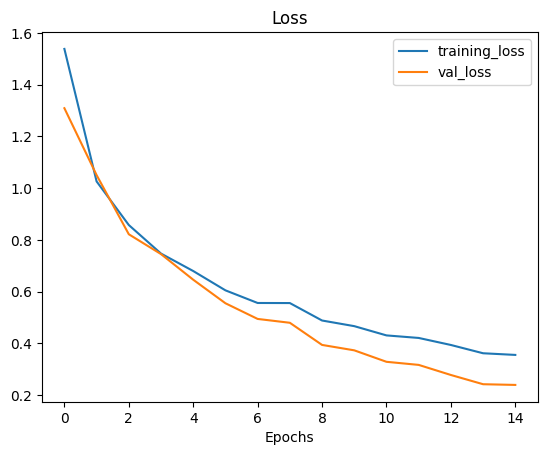

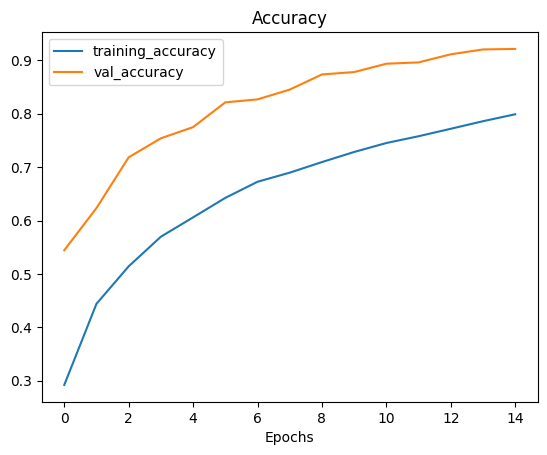

In [23]:
plot_loss_curves(history)

190/190 [==============================] - 220s 1s/step
Confusion Matrix
Classification Report for T-Stage
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        81
          1a       0.94      1.00      0.97        79
          1b       0.93      0.99      0.96       524
          1c       0.98      0.84      0.90      1535
           2       0.52      0.99      0.68       229
          2a       0.95      0.96      0.95      1050
          2b       0.97      1.00      0.98       510
           3       0.97      0.89      0.93      1565
           4       0.86      1.00      0.93       480
          is       1.00      1.00      1.00        10

    accuracy                           0.92      6063
   macro avg       0.91      0.97      0.93      6063
weighted avg       0.94      0.92      0.93      6063



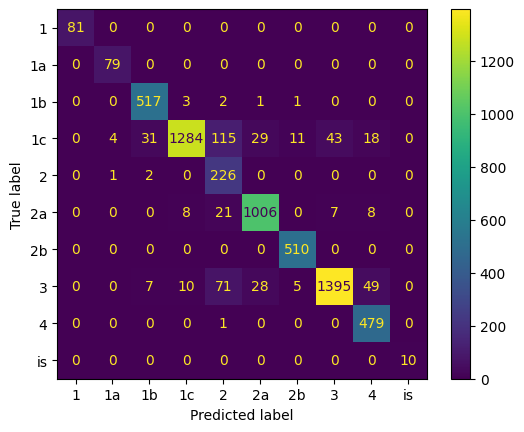

In [33]:
t_class = ['1','1a','1b','1c','2','2a','2b','3','4','is'] 
t_Y_pred = mobilenet_mod.predict(t_test_ds) #predictions
t_Y_ground = t_test_df.t.to_list()
t_y_pred = np.argmax(t_Y_pred,axis=1)
print('Confusion Matrix')
cm = confusion_matrix(t_test_ds.classes, t_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=t_class)
cmd.plot()

print('Classification Report for T-Stage')

print(classification_report(t_test_ds.classes, t_y_pred, target_names=t_class))
